# Uso de spaCY

In [ ]:
import nltk # importar natural language toolkit
nltk.download('punkt')
nltk.download('stopwords') # modulo para descargar stopwords en diferentes idiomas
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Caso aplicado: ¿Cómo podemos predecir el sentimiento asociado con una interacción con el cliente?

In [ ]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

rcParams['figure.figsize'] = 10, 8
%matplotlib inline

# Metas

Después de trabajar en este caso, debería poder aplicar el análisis de sentimientos a los problemas comerciales. Comprenderá cómo utilizar técnicas de clasificación de texto para crear un modelo de análisis de opiniones y podrá aplicar modelos de opiniones a datos del mundo real.

Habrá adquirido experiencia en el uso de varias técnicas diferentes de vectorización y creación de modelos, utilizando bibliotecas populares de Python como scikit-learn y gensim. Habrá utilizado tanto vectorizaciones basadas en conteo como incrustaciones de palabras, y comprenderá los pros y los contras de cada una.

# Introducción
**Contexto empresarial**. Eres un científico de datos para una gran empresa de comercio electrónico. Tienes decenas de miles de clientes que escriben reseñas sobre productos cada día. Cada revisión contiene comentarios textuales junto con un sistema de calificación de 1 a 5 estrellas (siendo 1 la menos satisfecha y 5 la más satisfecha).

También tiene un equipo de atención al cliente que interactúa con los clientes a través de servicios de llamadas y mensajes. Su empresa también recopila comentarios sobre las experiencias de sus clientes con la interacción del sitio web después de cada compra. Ni este comentario ni el servicio de mensajería tienen un número de calificación. La empresa quiere cuantificar la satisfacción del cliente proveniente de estas interacciones no calificadas para ayudar con futuras decisiones comerciales (por ejemplo, determinar qué tan bien se están desempeñando sus diversos agentes de servicio al cliente).

**Problema de negocio** Su tarea es construir modelos que puedan identificar el sentimiento (positivo o negativo) de cada una de estas interacciones no calificadas.

**Contexto analitico** Los datos son un conjunto de reseñas en formato de archivo CSV. Combinaremos lo que aprendimos sobre el procesamiento de texto y los modelos de clasificación para desarrollar algoritmos capaces de clasificar las interacciones por sentimiento.

El caso está estructurado de la siguiente manera: 1) leerá y analizará los datos del texto de entrada y las variables de respuesta correspondientes (calificaciones); 2) realizara un preprocesamiento básico para preparar los datos para el modelado; 3) aprendera y aplicara varias formas de caracterizar el texto de reseñas; y finalmente 4) construira modelos de aprendizaje automático para clasificar el texto como mostrando un sentimiento positivo o negativo (1 o 0).

# Lectura de datos y analisis basico

In [ ]:
!gdown 1XEBJ_LFXAOsrT9MEg3JhvQyoOGUJVtqt

Downloading...
From (original): https://drive.google.com/uc?id=1XEBJ_LFXAOsrT9MEg3JhvQyoOGUJVtqt
From (redirected): https://drive.google.com/uc?id=1XEBJ_LFXAOsrT9MEg3JhvQyoOGUJVtqt&confirm=t&uuid=8c4b6881-bb83-4657-86ec-fd36e6f942f5
To: /content/Reviews.csv
100% 301M/301M [00:07<00:00, 39.4MB/s]


In [ ]:
import pandas as pd
amazon_reviews = pd.read_csv('Reviews.csv')
# Seleccionando solo los primeros 10,000 registros para calculo mas rapido
amazon_reviews = amazon_reviews[:10000]
amazon_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
amazon_reviews.shape

(10000, 10)

Columnas del dataset:

- **ID**: valor unico para cada fila
- **ProductId**: una referencia del producto sobre la reseña
- **UserId**: una referencia del usuario que dejo el review
- **HelpfulnessNumerator**: numero de lectores que han indicado que la reseña ayuda o es interesante
- **HelpfulnessDenominator**: numero total de personas que han dado una indicacion de si la reseña ha sido util o no
- **Score**:  rating (1-5)
- **Time**: fecha formato timestamp que indica cuando se creo la revision
- **Summary**: El resumen escrito por el usuario de lo que trata la reseña
- **Text**: la revisión escrita por el usuario

Miremos la distribucion del numero de palabras por review

Text(0, 0.5, 'Frecuencia')

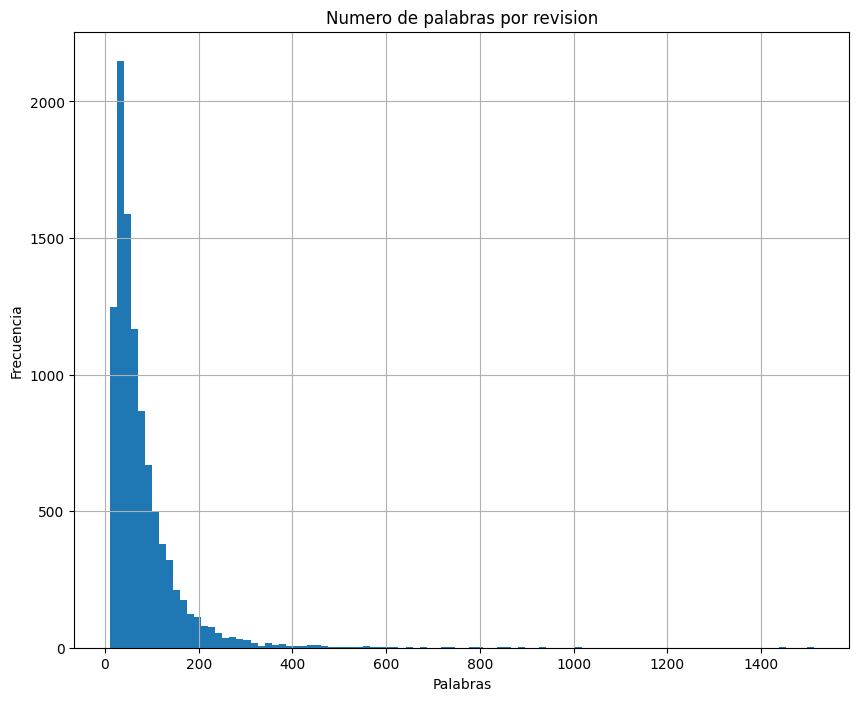

In [ ]:
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por revision')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [ ]:
words_per_review.mean()

77.9028

Distrobucion de los ratings

In [ ]:
amazon_reviews.Score.value_counts()

,count
Score,
5,6183
4,1433
1,932
3,862
2,590


In [ ]:
percent_val = 100 * amazon_reviews.Score.value_counts()/amazon_reviews.shape[0]
percent_val

,count
Score,
5,61.83
4,14.33
1,9.32
3,8.62
2,5.90


Text(0, 0.5, 'Porcentaje (%)')

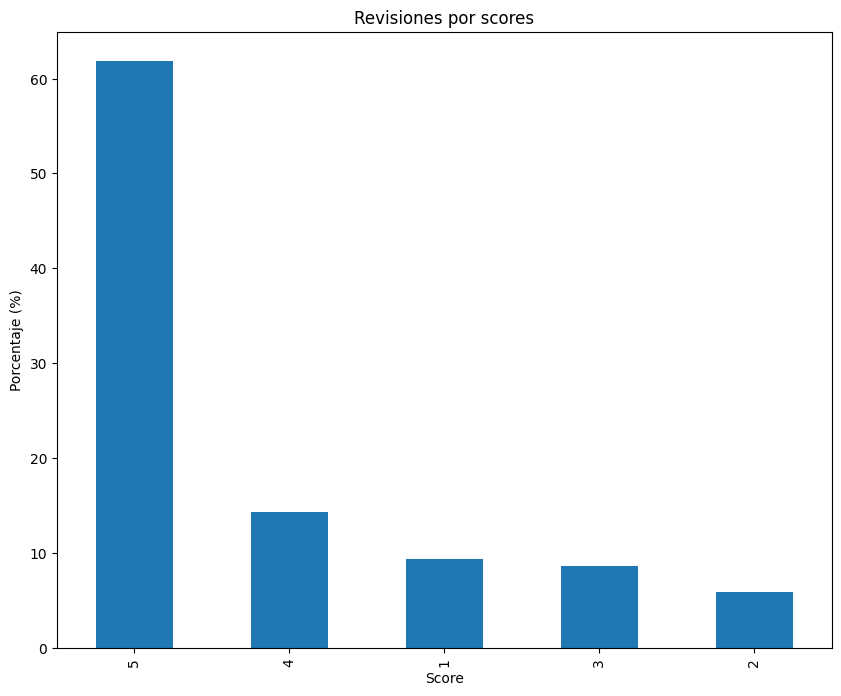

In [ ]:
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

la distribucion es asimetrica, con un gran valor para los ratings de 5s y pocos par 3,2 y 1

# Wordcloud

4157740


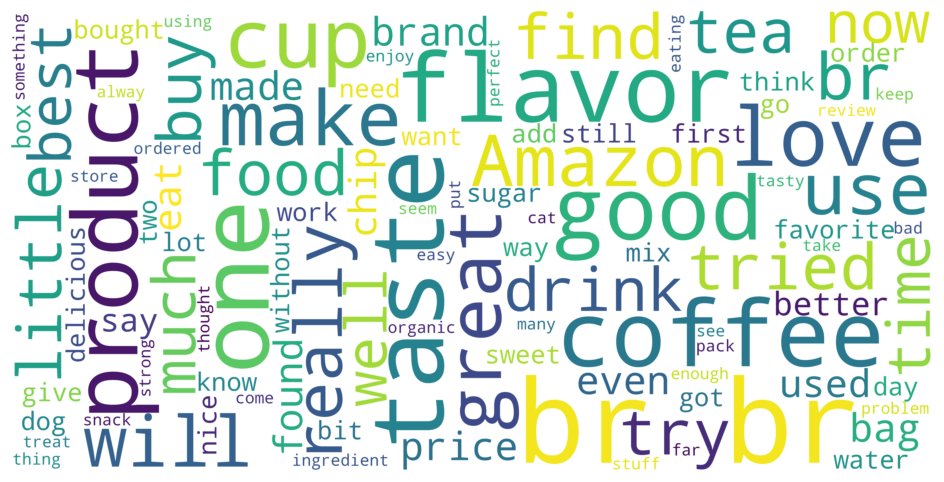

In [ ]:
word_cloud_text = ''.join(amazon_reviews.Text)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

El wordcloud muestra que hat muchos reviews que hablan sobre temas de comida (cafe, sabores, sabor, bebidas), tambien se observan otras palabras como bueno, amor y el mejor

# Estandarizacion de ratings para analisis de sentimiento

Para propositos del analisis de sentimiento convertiremos todos los ratings en valores binarios con las siguientes reglas:
- ratings de 4 o 5 seran convertidos a 1 (positivo)
- ratings de 1 o 2 seran convertidos a 0 (negativo)
- ratings de 3 seran removidos del analisis

In [ ]:
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3, 1, 0)
amazon_reviews['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
1,7616
0,2384


!= negativo

In [ ]:
# removiendo neutrales
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

Text(0, 0.5, 'Frecuencia')

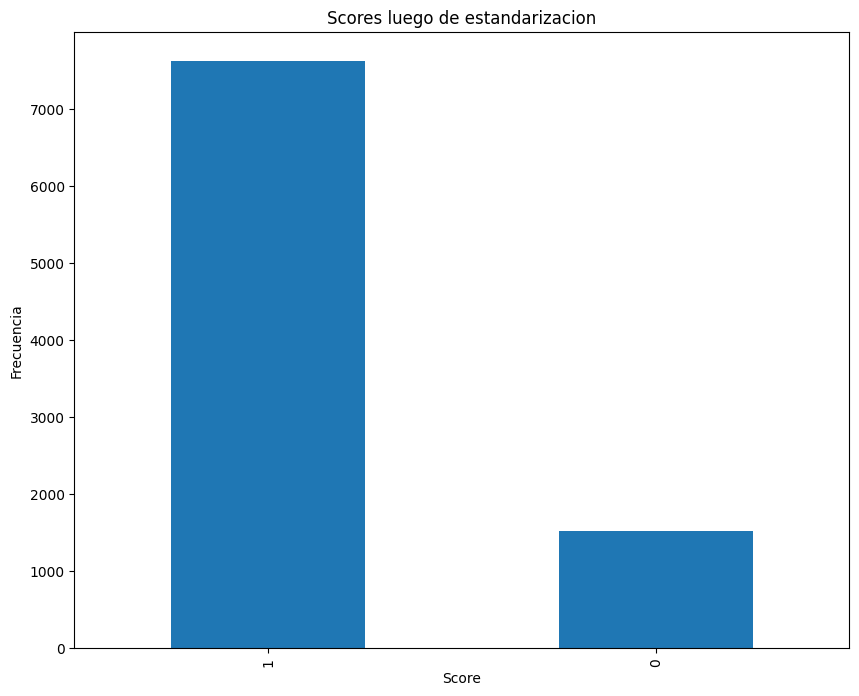

In [ ]:
#rcParams['figure.figsize'] = 8, 5
amazon_reviews.Sentiment_rating.value_counts().plot.bar()
plt.title('Scores luego de estandarizacion')
plt.xlabel('Score')
plt.ylabel('Frecuencia')

# Preprocesamiento con NLTK

Recordemos que el preprocesamiento de texto y la normalizacion es crucial antes de desarrollar un modelo de NLP, algunos pasos importantes son:
### Convertir palabras a minusculas


In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())

### Remover caracteres especiales


In [ ]:
from nltk import word_tokenize
import nltk

nltk.download('punkt')

token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Numero de tokens unicos antes:  27509
Numero de tokens unicos nuevos:  22473


In [ ]:
(22865-27899)/27899

-0.18043657478762679

El numero de tokens han bajado en cerca del 18% con la normalizacion

¿Es la eliminación de caracteres especiales incluso una buena idea? ¿Cuáles son algunos ejemplos de caracteres que probablemente sería seguro eliminar y cuáles no?

Eliminar caracteres especiales es una decisión subjetiva, especialmente en casos como este. Las personas a menudo usan caracteres especiales para expresar sus emociones y pueden dejar una reseña como "¡¡¡Este producto es el peor!!!", mientras que una reseña positiva podría ser "Este producto es el mejor". ¡Me encantó!' Aquí, la presencia de signos de exclamación indica claramente algo sobre el sentimiento subyacente, por lo que eliminarlos puede no ser una buena idea.

Por otro lado, eliminar la puntuación sin carga emocional, como las comas, los puntos y el punto y coma, probablemente sea seguro.

En aras de la simplicidad, procederemos eliminando todos los caracteres especiales; sin embargo, vale la pena tener en cuenta que esto es algo para revisar dependiendo de los resultados que obtengamos más adelante. Lo siguiente da una lista de todos los caracteres especiales en nuestro conjunto de datos:

In [ ]:
# Seleccionando los caracteres no alfa numericos que no son espacios
special_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'`', '%', '+', '$', ';', ']', '=', '!', ',', ':', '{', '<', '"', '§', '}', '~', '?', '*', '>', '&', '_', '(', '.', '[', '/', '^', ')', '#', "'", '@', '®', '-'}


Ahora removamos los caracteres especiales de los reviews

In [ ]:
import re
review_backup = amazon_reviews.reviews_text_new.copy()
amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

Miremos como se ven algunos de los resultados luego de remover esto

In [ ]:
print("Review anterior:")
review_backup.values[6]

Review anterior:


"this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!"

In [ ]:
print("Review nuevo:")
amazon_reviews.reviews_text_new[6]

Review nuevo:


'this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it '

El numero de tokens unicos que se han borrado son

In [ ]:
token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos despues: ", len(set(tokens)))

Numero de token unicos antes:  27509
Numero de tokens unicos despues:  18039


### Remover stopwords y palabras de alta frecuencia


In [ ]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Encontremos las palabras de alta y baja frecuencia, que definiremos como el 1 % de las palabras que aparecen con más frecuencia en las reseñas, así como el 1 % de las palabras que aparecen con menos frecuencia en las reseñas (después de ajustar por mayúsculas y minúsculas y caracteres especiales).

In [ ]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('the', 28122),
 ('i', 25705),
 ('and', 19980),
 ('a', 18505),
 ('it', 16143),
 ('to', 15137),
 ('of', 12067),
 ('is', 11063),
 ('this', 10530),
 ('br', 9361)]

Text(0, 0.5, 'Frecuencia')

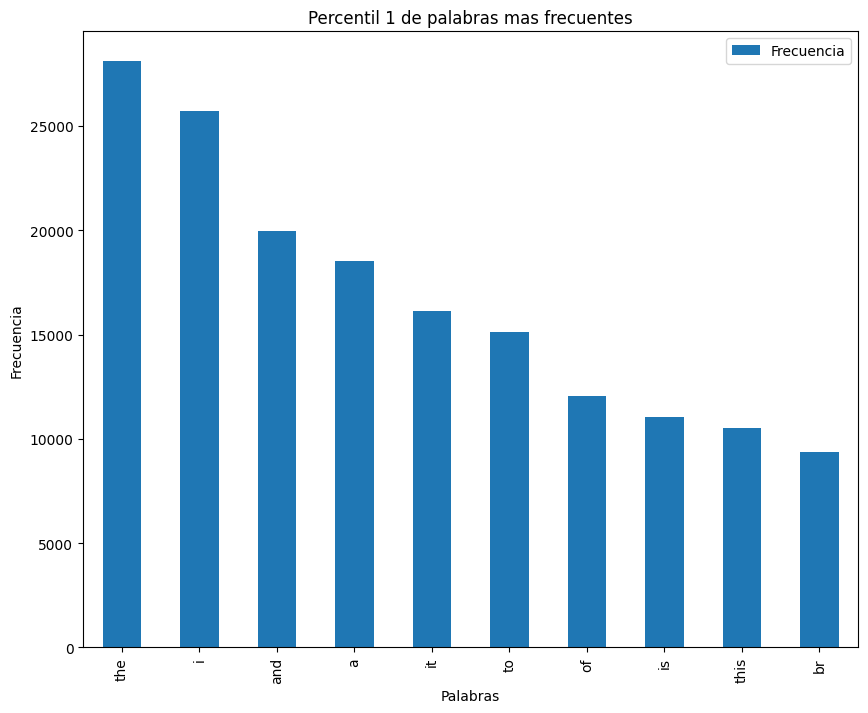

In [ ]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [ ]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('pruchase', 1),
 ('slick', 1),
 ('cloured', 1),
 ('innocuous', 1),
 ('espensive', 1),
 ('marketer', 1),
 ('strofoam', 1),
 ('destroyers', 1),
 ('ruth', 1),
 ('gleaning', 1)]

In [ ]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

Las stopwords y las palabras de alta/baja frecuencia ahora se han agregado a noise_words, que se eliminarán de las revisiones antes de entrenar los modelos de aprendizaje automático.

Es poco probable que las stopwords sean tan útiles, ya que esperamos que aparezcan con la misma frecuencia en las críticas positivas y negativas. Las palabras poco comunes pueden ser más significativas y, en teoría, podrían indicar el sentimiento de la revisión

### Stemming y Lemantizacion

Si quieren profundizar en los conceptos de [stemming](http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer), y[lemmatization](http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#module-nltk.stem.wordnet) y otros tipos de normalizaciones pueden encontrar una buena introduccion en: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

nltk.download('wordnet')

from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Los algoritmos de **Stemming** funcionan cortando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes que se pueden encontrar.

Por otro lado, la **lematización** toma en consideración el análisis morfológico de las palabras. Por lo tanto, la **lematización** tiene en cuenta la gramática de la palabra e intenta encontrar la palabra raíz en lugar de simplemente llegar a la palabra raíz mediante métodos de fuerza bruta.

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Proveer una palabra que sera lemantizada
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


Se puede ver que obtenemos una raíz de significado de Lemmatizer, mientras que Stemmer simplemente recorta y extrae la primera parte importante de la palabra.

# Creacion de modelo de ML

In [ ]:
amazon_reviews[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


Las variables independientes o características del modelo se derivan del texto de revisión. Previamente, discutimos cómo podemos usar **n-grams** para crear características, y específicamente cómo la bolsa de palabras es la interpretación más simple de estos n-gramas, sin tener en cuenta el orden y el contexto por completo y solo enfocándonos en la frecuencia/recuento. Usemos eso como punto de partida.

# Vectorizacion (BOW)

CountVectorizer es una clase de Python que da cuenta automáticamente de ciertos pasos de preprocesamiento, como la eliminación de palabras vacías, la derivación, la creación de n-gramas y la tokenización de palabras:

In [ ]:
# Creacion de metodo para stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Usemos esto para crear una bolsa de palabras de las reseñas, excluyendo las palabras irrelevantes que identificamos anteriormente:

In [ ]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

Una vez que se prepara la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y de prueba. También podríamos dividir los datos después de vectorizarlos, pero es útil dividir los datos lo antes posible en el proceso. Esto significa que una vez que hemos generado nuestras predicciones, podemos compararlas más fácilmente con los textos originales, antes de que hayan sido preprocesadas y vectorizadas.

In [ ]:
reviews_train, reviews_test = train_test_split(amazon_reviews, test_size=0.2, random_state=0)

In [ ]:
X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'need', 'sha', 'wo'] not in stop_words.
  warnings.warn(


Tengan en cuenta que llamamos a ```fit_transform``` para vectorizar nuestro conjunto de entrenamiento y ```transform``` para vectorizar nuestro conjunto de prueba. Esto genera las asignaciones de vectorización solo en los datos del conjunto de entrenamiento, que es una restricción a la que nos enfrentaríamos en un problema del mundo real (no tener acceso a los datos de prueba durante el tiempo de entrenamiento).

Por lo tanto, puede haber algunas palabras en el conjunto de prueba que no sabemos cómo vectorizar y se omitirán.

In [ ]:
y_train_bow = reviews_train['Sentiment_rating']
y_test_bow = reviews_test['Sentiment_rating']

In [ ]:
y_test_bow.value_counts() / y_test_bow.shape[0]

,count
Sentiment_rating,
1,0.847921
0,0.152079


Los datos de prueba contienen 84% de opiniones positivas. El modelo de predicción más simple que podríamos pensar sería uno que prediga "positivo" para cada entrada. Llamaríamos a esto un modelo "ingenuo", y constituye una línea de base útil. En este caso, dicho modelo obtendría un 84 % de precisión, por lo que podemos considerarlo como una puntuación de referencia que nuestro modelo de aprendizaje automático debe superar.

## Modelo de regresion logistica

In [ ]:
# Entrenar el modelo
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predecir el output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.942550505050505
Accuracy:  90.04376367614879


In [ ]:
test_pred_lr_prob

array([[7.97523525e-01, 2.02476475e-01],
       [2.70652234e-09, 9.99999997e-01],
       [5.15736118e-02, 9.48426388e-01],
       ...,
       [1.23706586e-04, 9.99876293e-01],
       [9.96584969e-01, 3.41503068e-03],
       [9.18000455e-02, 9.08199955e-01]])

In [ ]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [ ]:
predictions = pd.DataFrame()
predictions['Text'] = reviews_test['Text']
predictions['Actual_Score'] = reviews_test['Score']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [ ]:
predictions.head(5)

,Text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
7419,These truffles are not as great as they are ma...,2,0,0,0.202476
4315,Ok--I just bought BIsquick GF and the first th...,4,1,1,1.000000
1781,I love these chips so much... and I can't get ...,5,1,1,0.948426
962,I purchased this because I read that it was a ...,2,0,0,0.363879
7289,I do like the idea of these crackers for glute...,2,0,1,0.954065


In [ ]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.9004376367614879

En la columna ```Predicted_probability```, puede ver la confianza que tenía el modelo en sus predicciones, siendo las probabilidades muy cercanas a 0 predicciones de sentimientos negativos muy confiables y las probabilidades muy cercanas a 1, predicciones de sentimientos positivos muy confiables.

Utilice esta información para encontrar el caso en el que el modelo tenía más confianza al predecir que una reseña tenía un sentimiento negativo cuando la puntuación real era positiva.

Mire el texto y escriba algunas oraciones de análisis sobre por qué cree que el modelo se equivocó

In [ ]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].sort_values(by=["Predicted_probability"]).head(3)

,Text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
7692,My little girl (6 months) can't stomach any fo...,5,1,0,0.000719
4166,The first time I tried this product to make pa...,4,1,0,0.002114
6612,"When I opened the package, I only found 11 pac...",4,1,0,0.006040


In [ ]:
predictions.loc[7692].values

array(["My little girl (6 months) can't stomach any formula.  Even Nutramigen, at $35 per can made her colicky and sick (accompanied with the worst smelling spit up).  The expensive formulas smelled bad, and tasted worse, I hated giving them to her.  Goats milk was recommended to me.  Her doctor's only objection was that it was low in Folic Acid and tended to dehydrate babies.  Well, Meyenberg Powdered Milk  is fortified with Folic Acid, so dilute it with a little extra water and you're in business!  I now have the happiest infant you've ever seen.  Enfamil can take that nasty chemical soup they call formula and shove it, I'll never go back.<br /><br />You can get the formula Recipe at:<br />[...]<br /><br />There have been concerns about arsenic in rice syrup lately, so I have been using Lyle's Golden Syrup, and she likes it fine (Also it's the best pancake syrup you'll ever have).  I am going to try barley malt syrup next, it is chemically more similar to rice syrup.",
       5, 1, 0

Podemos ver que la reseña tiene un tono muy negativo y utiliza palabras que la modelo probablemente ha aprendido a asociar fuertemente con malas reseñas como "caro", "malo", "peor", "odiado", "desagradable", " nunca". Sin embargo, todos estos en realidad están dirigidos a un producto diferente. El autor dice que después de comprar este producto tiene el "bebé más feliz", pero eso no es lo suficientemente fuerte como para contrarrestar todos los aspectos negativos de la reseña.

Modifique el conjunto de características en el modelo para incluir bigramas, trigramas y 4-grams. No elimine las palabras irrelevantes definidas anteriormente antes de presentarlas. (Sugerencia: establece ngram_range=(1,4).)

Al mismo tiempo, experimente con el ajuste de hiperparámetros. Cambie el valor C del clasificador de regresión logística a 0,9.

In [ ]:
# Cambios con respecto al código anterior
# 1. Aumentar los n-gramas de solo tener 1 gramo a (1 gramo, 2 gramos, 3 gramos y 4 gramos)
# 2. Incluir las palabras vacías en las características de la bolsa de palabras
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Observe el aumento de funciones con la inclusión de palabras vacías
X_train_bow

<7310x1054259 sparse matrix of type '<class 'numpy.int64'>'
	with 2036674 stored elements in Compressed Sparse Row format>

In [ ]:
# Cambios en la regresión logística
# Cambio de la sanción de regularización por defecto de l2 a l1
# Cambiando el parámetro de costo C a 0.9
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")

In [ ]:
# Entrenar el modelo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predecir resultados
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9554579673776662
Accuracy:  92.23194748358861


La precisión ha saltado del 90% al 92,2%. Este es un ejemplo de lo que el simple ajuste de hiperparámetros y la modificación de características de entrada pueden hacer en el rendimiento general. Incluso podemos obtener características interpretables de esto en términos de lo que más contribuyó al sentimiento positivo y negativo.

In [ ]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names_out(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
374800,great,1.382526
256072,delicious,0.979694
366512,good,0.864971
677656,perfect,0.844286
299760,excellent,0.838121
855190,the best,0.826370
534066,love,0.819486
143456,best,0.813387
593253,nice,0.780972
536985,loves,0.660368


In [ ]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
1037701,worst,-0.526030
1007881,were,-0.529210
982174,very disappointed,-0.540921
120594,away,-0.546831
730653,return,-0.547383
801742,stick,-0.561657
121444,awful,-0.570031
997363,waste,-0.591713
265649,disappointing,-0.598279
820835,t,-0.654783


## Random forest

In [ ]:
rf_model_all = RandomForestClassifier(n_estimators=100)

# Entrenamiento
rf_model_all.fit(X_train_bow, y_train_bow)

# predicciones
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

In [ ]:
print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9278659084106555
Accuracy:  86.81619256017505


Esto no es tan bueno como la regresión logística. Podemos obtener los n-gramas que fueron más importantes para las predicciones de la siguiente manera:

In [ ]:
feature_importances = pd.DataFrame(
    rf_model_all.feature_importances_,
    index=bow_counts.get_feature_names_out(),
    columns=['importance']
)

In [ ]:
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
return,0.002614
great,0.001991
waste,0.001903
disappointing,0.001880
not,0.001879
worst,0.001610
not worth,0.001410
very disappointed,0.001321
disappointed,0.001212
refund,0.001203


# Vectorizacion TF-IDF

Por supuesto, la bolsa de palabras no es la única forma de caracterizar el texto. Otro método, que mencionamos brevemente antes, es el método TF-IDF. Esto evalúa qué tan importante es una palabra para un documento dentro de una gran colección de documentos (es decir, corpus). La importancia aumenta proporcionalmente en función del número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus.

La TF-IDF es el producto de dos términos. El primero calcula la frecuencia de término normalizada (TF); es decir, el número de veces que aparece una palabra en un documento dividido por el número total de palabras en ese documento. El segundo término es la Frecuencia Inversa de Documentos (IDF), calculada como el logaritmo del número de documentos en el corpus dividido por el número de documentos

Menos formalmente, ¿qué significa esto?

- Si una palabra aparece con mucha frecuencia en un documento específico, es probable que sea significativa.
- Si una palabra aparece con mucha frecuencia en casi todos los documentos del corpus, es poco probable que sea significativa.
- Por tanto, una palabra que aparece a menudo en un documento pero rara vez en el resto del corpus merece especial atención.

TF-IDF no solo cuenta cada palabra, sino que aplica una ponderación para que las palabras comunes reciban menos atención y las palabras raras reciban más.

Volvamos a presentar nuestro conjunto original de revisiones basado en TF-IDF y dividamos las funciones resultantes en conjuntos de entrenamiento y prueba:

In [ ]:
# Cree un vectorizador: aún alimentamos nuestras stopwords, aunque
# estos son menos relevantes ahora ya que TF-IDF los ponderaría menos
# de todas formas.
tfidf_counts = TfidfVectorizer(
    stop_words=noise_words,
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.reviews_text_new)
X_test_tfidf = tfidf_counts.transform(reviews_test.reviews_text_new)

## Regresion logistica

In [ ]:
# Crear el clasificador
lr_model_tf_idf = LogisticRegression(solver="liblinear")

# Entrenar
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9343419062027231
Accuracy:  88.12910284463895


Aquí hemos logrado una precisión del 88 % con TF-IDF en comparación con el 90 % con 1-gram. Es difícil saber exactamente por qué este algoritmo de vectorización más sofisticado conduce a peores resultados, pero podría ser que penalizar palabras que son comunes en todo el corpus genere una desventaja para este conjunto de datos en particular. TF-IDF suele ser útil cuando los datos de prueba son muy diferentes de los datos de entrenamiento, lo que permite que se desprioricen las palabras que solo son comunes en el conjunto de entrenamiento.

Trate de aumentar la precisión del modelo por

- configurando ```ngram_range=(1,4)``` en el Vectorizador
- no eliminar las palabras irrelevantes de antemano en el Vectorizador
- configurando C=10 en el clasificador LogisticRegression
- estableciendo penalización="l1" en el clasificador LogisticRegression

In [ ]:
tfidf_counts = TfidfVectorizer(
    stop_words=noise_words,
    ngram_range=(1,3)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.reviews_text_new)
X_test_tfidf = tfidf_counts.transform(reviews_test.reviews_text_new)

In [ ]:
# definiendo la clase del modelo
lr_model_tf_idf_new = LogisticRegression(solver="liblinear")

# Entrenar
lr_model_tf_idf_new.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

# Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all)*100)

F1 score:  0.9247761194029851
Accuracy:  86.2144420131291


Esta es una mejora con respecto a nuestro resultado anterior, pero hicimos cuatro cambios al mismo tiempo, por lo que no sabemos cuáles ayudaron y cuánto.

Probar diferentes hiperparámetros para mejorar su modelo se denomina ajuste de hiperparámetros y es un campo enorme por sí solo. Puede imaginar cómo ejecutar este modelo 16 veces, una vez con cada posible configuración de hiperparámetros que hemos probado, sería un poco complicado de seguir, ¡y esto es solo con 4 hiperparámetros y dos valores para cada uno! Con 100 o 1000 de hiperparámetros y 100 o 1000 de valores para cada uno, las combinaciones totales crecen muy rápidamente.

Para ayudar con esto, scikit-learn proporciona la llamada funcionalidad de "GridSearch", donde puede configurar una canalización y especificar los rangos de hiperparámetros que desea "buscar". Scikit-learn probará cada combinación y entrenará y evaluará el modelo para cada caso, diciéndole cuál funcionó mejor.

También podemos encontrar nuestras características más importantes nuevamente, como se muestra a continuación:

In [ ]:
lr_weights = pd.DataFrame(
    list(
        zip(tfidf_counts.get_feature_names_out(), lr_model_tf_idf_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
178252,loves,2.196731
104596,excellent,2.190852
278718,smooth,1.936851
144531,highly,1.869055
337543,wonderful,1.814612
279226,snack,1.761867
121872,fresh,1.469528
138783,happy,1.469288
291886,stores,1.394833
304319,tasty,1.379256


In [ ]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
191438,money,-2.140400
252309,return,-2.195114
147152,horrible,-2.195596
22853,away,-2.232038
340027,worst,-2.288286
310578,thought,-2.475898
332253,weak,-2.550800
331548,waste,-2.572924
25457,bad,-3.180275
88350,disappointed,-3.960054



**En nuestro caso, la creación de características usando TF-IDF nos dio una precisión del 92 % con características muy interpretables. Esta es una buena combinación, por lo que consideramos que este es el mejor modelo para nosotros aquí**.

Tenga en cuenta que para un experimento real, habríamos dividido nuestro conjunto de datos en tres partes, no solo en dos. Cuando se ejecuta un experimento varias veces con diferentes parámetros, es casi seguro que algunos resultados serán mejores simplemente por casualidad, y es mala ciencia seleccionar el modelo con mejor desempeño después de docenas o cientos de ejecuciones.

Para evitar este problema, los datos deben dividirse en conjuntos de "entrenamiento", "prueba" y "validación". El conjunto de "prueba" debe reservarse al comienzo del experimento y nunca mirarse. El modelo debe ajustarse utilizando el conjunto de "validación".

Solo una vez que el experimentador esté satisfecho con el modelo al mejorar el rendimiento en el conjunto de validación, se debe ejecutar el modelo en el conjunto de prueba y esos resultados finales se toman como los resultados finales del experimento.

# Conclusiones

En este caso, limpiamos y destacamos un conjunto de datos de reseñas de Amazon y construimos algunos modelos de clasificación en estas características para predecir el sentimiento. Vimos que la bolsa de palabras y TF-IDF brindaban características interpretables, mientras que las incrustaciones de palabras realmente no. Al aumentar el conjunto de n-gramas que usamos de 1-gram a 4-grams, pudimos obtener la precisión de nuestro modelo de regresión logística hasta en un 92 %.

# Para llevar

La construcción de modelos de aprendizaje automático en texto es una disciplina muy complicada. Algunas cosas importantes a tener en cuenta son las siguientes:

1. Aunque existen diferentes tipos de preprocesamiento involucrados en los datos textuales, no todo tiene que aplicarse en cada caso. Por ejemplo, cuando se trata de mensajes de texto, los caracteres especiales pueden representar información importante y no es necesario eliminarlos. Además, las mayúsculas pueden significar que alguien está enojado y representan gritos, por lo que las mayúsculas y las minúsculas pueden representar información valiosa. En otras situaciones, es más valioso normalizarlas.

2. El ajuste de hiperparámetros en los modelos de aprendizaje automático es un paso muy importante y, si bien los hiperparámetros predeterminados funcionan bien en muchos casos, a menudo se puede obtener un rendimiento adicional al ajustarlos. Se deben probar diferentes conjuntos de parámetros para ver qué contribuye al mejor modelo.

3. Cada tarea de clasificación en NLP es diferente, pero el proceso a seguir es similar al que hicimos en este caso:  **discutir los datos -> crear características a partir del texto -> entrenar modelos -> evaluar modelos**.